# Goal : Confirm with simple model monotonous strain is not complicated

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nbimporter
import random

In [2]:
from Functions import RMA_newton

Importing Jupyter notebook from Functions.ipynb


In [3]:
def strain_non_linear(N,p):
    return 0.2*np.array(range(N+1))**p/N**p

def strain_non_linear2(N,p):
    final_value = random.uniform(0,0.2)
    return final_value*np.array(range(N+1))**p/N**p

def strain_linear(N):
    final_value = random.uniform(0,0.2)
    slope       = final_value/N
    return slope * np.array(range(N+1))

### 0. Intuition in a Graph

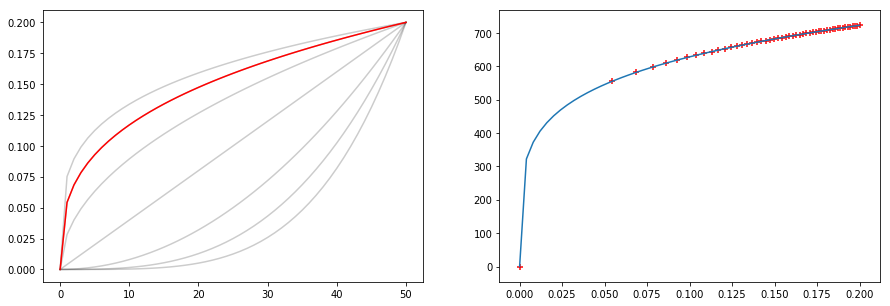

In [4]:
N=50
p=[1/4,1/3,1/2,1,2,3,4]

E = 200000
b = 0.001
A = 1000
a = 0.2

strains_int=[]
stress_int=[]

for i in range(7):
    new_strain=strain_non_linear(N,p[i])
    strains_int.append(new_strain)
    rma=RMA_newton(new_strain)
    rma.activate(E,A,b,a)
    stress_int.append(rma.stress)

plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,2,1)
for i in strains_int:
    plt.plot(i,color='k',alpha=0.2)
plt.plot(strains_int[1],color='red')
plt.subplot(1,2,2)
plt.plot(strains_int[3],stress_int[3])
#plt.scatter(strains_int[0],stress_int[0],marker='+',color='red')
plt.scatter(strains_int[1],stress_int[1],marker='+',color='red')
#plt.scatter(strains_int[2],stress_int[2],marker='+',color='red')
#plt.scatter(strains_int[4],stress_int[4],marker='+',color='red')
#plt.scatter(strains_int[5],stress_int[5],marker='+',color='red')
#plt.scatter(strains_int[6],stress_int[6],marker='+',color='red')
plt.show()

Any of the lines are going to be represented by a scatter similar to the one on the strain-stress diagram

### I. Building Dataset

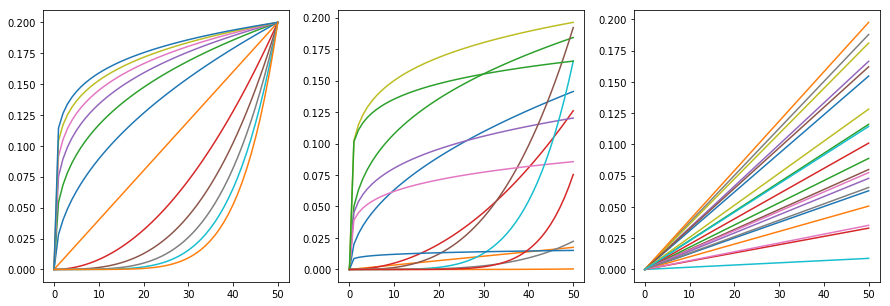

In [5]:
N=50
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
for i in range(6):
    plt.plot(strain_non_linear(N,1/(i+2)))
    plt.plot(strain_non_linear(N,i+1))
plt.subplot(1,3,2)
for i in range(7):
    plt.plot(strain_non_linear2(N,1/(i+2)))
    plt.plot(strain_non_linear2(N,i+1))
plt.subplot(1,3,3)
for i in range(20):
    plt.plot(strain_linear(N))
plt.show()

In [6]:
N=50
strains=[]
# Linear Strains
for i in range(48):
    strains.append(strain_linear(N))
# Non Linear Strains
for i in range(20):
    strains.append(strain_non_linear(N,1/(i+1)))
for j in range(6):
    strains.append(strain_non_linear(N,j+2))
for i in range(20):
    strains.append(strain_non_linear2(N,1/(i+1)))
for j in range(6):
    strains.append(strain_non_linear2(N,j+2))

In [7]:
print("number of samples:",len(strains))
print("number for training:",int(len(strains)*0.80))
print("number for testing:",len(strains)-int(len(strains)*0.80))

number of samples: 100
number for training: 80
number for testing: 20


In [8]:
E = 200000
b = 0.001
A = 1000
a = 0.2

stress=[]
for obj in strains:
    rma=RMA_newton(obj)
    rma.activate(E,A,b,a)
    stress.append(rma.stress)

In [9]:
ind1=np.random.choice(48, 40, replace=False)
ind2=np.random.choice(20, 16, replace=False)+48
ind3=np.random.choice(6, 4, replace=False)+68
ind4=np.random.choice(20, 16, replace=False)+74
ind5=np.random.choice(6, 4, replace=False)+94
ind_train = list(np.concatenate([ind1,ind2,ind3,ind4,ind5]))
ind_test  = [w for w in range(100) if (w not in ind_train)]

In [10]:
X_train=np.array(strains)[ind_train,:]
y_train=np.array(stress)[ind_train,:]
X_test=np.array(strains)[ind_test,:]
y_test=np.array(stress)[ind_test,:]

### II. Simple Model

In [69]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from matplotlib.colors import Colormap

#### a) Naive approach 1

In [24]:
#mlp=MLP((51,65,100,65,51),alpha=0.01,activation='tanh',learning_rate='adaptive',learning_rate_init=0.005,max_iter=10000)
reg=LinearRegression()

In [25]:
#mlp.fit(X_train,y_train)
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
#y_predict=mlp.predict(X_test)
y_predict=reg.predict(X_test)

In [27]:
#dist_error=y_predict-y_test

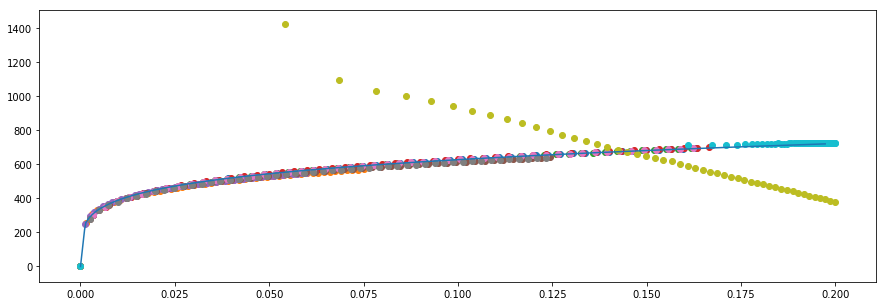

In [45]:
plt.plot(X_test[19,:],y_test[19,:])
for i in range(10):
    plt.scatter(X_test[i,:],y_predict[i],)

A little preprocessing would not hurt.

#### b) Naive approach 2

In [95]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', Lasso(alpha=0.01,max_iter=10000))])

In [96]:
model = model.fit(X_train, y_train)

/home/maxlavech/anaconda3/envs/stress_strain/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [97]:
y_predict = model.predict(X_test)

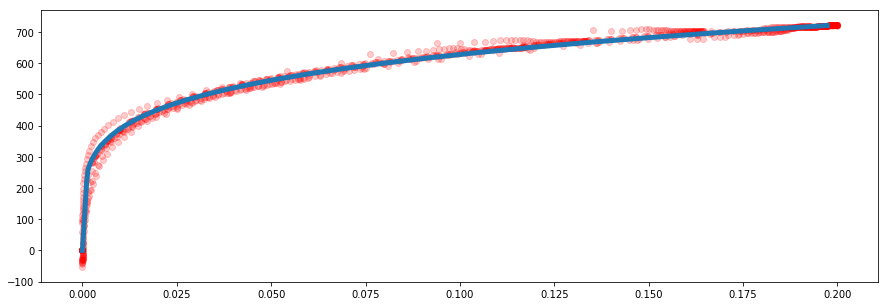

In [98]:
plt.plot(X_test[19,:],y_test[19,:],lw=5)
for i in range(20):
    plt.scatter(X_test[i,:],y_predict[i],color='red',alpha=0.2)

With little effort we reach "acceptable" results